<a href="https://colab.research.google.com/github/jremeh/Learning-Deep-Learning/blob/master/fastai2_intermediate_data_block_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
!pip install fastai2

     |████████████████████████████████| 184kB 2.8MB/s 


In [3]:
from fastai2.vision.all import *

In [4]:
path = untar_data(URLs.PETS)

### Building a Data Block from Scratch

In [5]:
fnames = get_image_files(path/"images")

In [6]:
dblock = DataBlock()

In [7]:
dsets = dblock.datasets(fnames)
dsets.train[0]

(Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_80.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_80.jpg'))

In [8]:
dblock = DataBlock(get_items = get_image_files)

In [9]:
dsets = dblock.datasets(path/"images")
dsets.train[0]

(Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_110.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/boxer_110.jpg'))

In [10]:
def label_func(fname):
    return "cat" if fname.name[0].isupper() else "dog"

Label the target with `get_y`

In [11]:
dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path/"images")
dsets.train[0]

(Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_171.jpg'),
 'dog')

Specify types to tell the data block PAI the inputs are images and targets are categories

In [12]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets(path/"images")
dsets.train[0]

(PILImage mode=RGB size=500x417, TensorCategory(1))

In [13]:
dsets.vocab

(#2) ['cat','dog']

Controlling how validation set is created by passing `splitter`

In [14]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter())

dsets = dblock.datasets(path/"images")
dsets.train[0]

(PILImage mode=RGB size=500x333, TensorCategory(0))

Last step is batch transform

In [15]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

Call `dataloaders` to convert `DataBlock` to `DataLoaders`

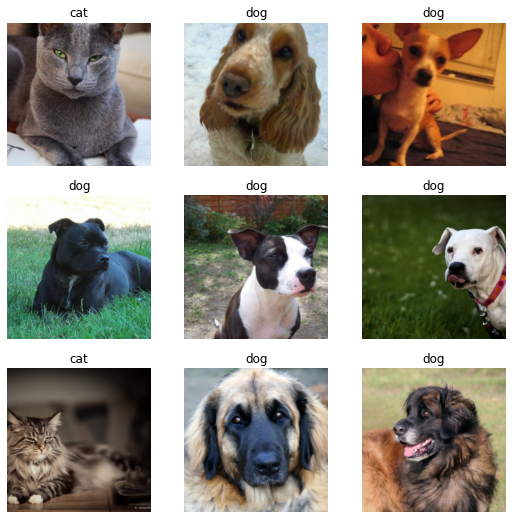

In [16]:
dls = dblock.dataloaders(path/"images")
dls.show_batch()

The way we usually build the data block in one go is by answering a list of questions:

- what is the types of your inputs/targets? Here images and categories
- where is your data? Here in filenames in subfolders
- does something need to be applied to inputs? Here no
- does something need to be applied to the target? Here the label_func function
- how to split the data? Here randomly
- do we need to apply something on formed items? Here a resize
- do we need to apply something on formed batches? Here no

## Image classification

In [17]:
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

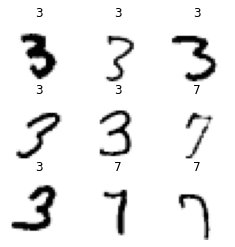

In [18]:
dls = mnist.dataloaders(untar_data(URLs.MNIST_TINY))
dls.show_batch(max_n=9, figsize=(4,4))

In [19]:
mnist.summary(untar_data(URLs.MNIST_TINY))

Setting-up type transforms pipelines
Found 1428 items
2 datasets of sizes 709,699
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_tiny/train/3/890.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False}
    starting from
      /root/.fastai/data/mnist_tiny/train/3/890.png
    applying parent_label gives
      3
    applying Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False} gives
      TensorCategory(0)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(0))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTen

In [20]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=Pipeline([attrgetter("name"), RegexLabeller(pat = r'^(.*)_\d+.jpg$')]),
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms())

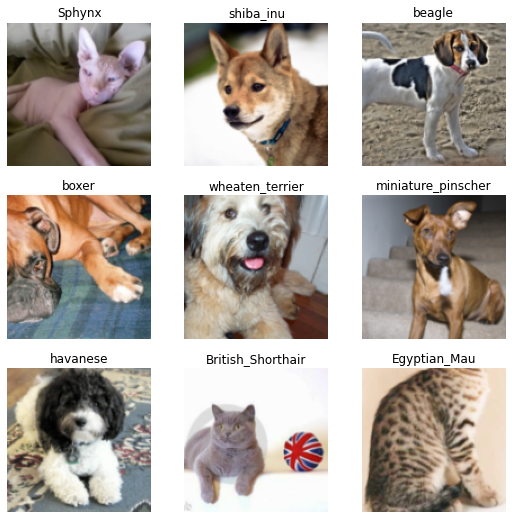

In [21]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")
dls.show_batch(max_n=9)

In [22]:
pascal_source = untar_data(URLs.PASCAL_2007)
df = pd.read_csv(pascal_source/"train.csv")

In [23]:
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [24]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=ColReader(0, pref=pascal_source/"train"),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

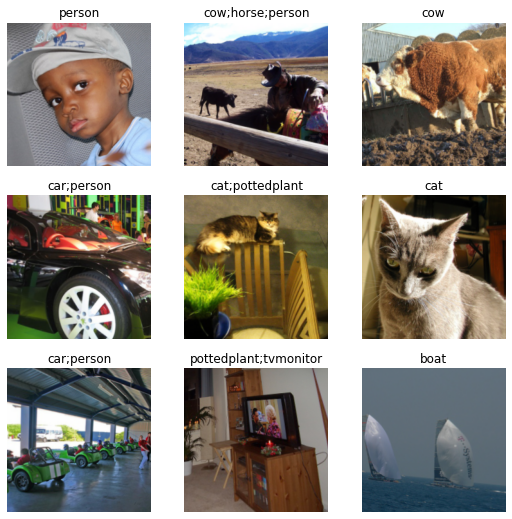

In [25]:
dls = pascal.dataloaders(df)
dls.show_batch()

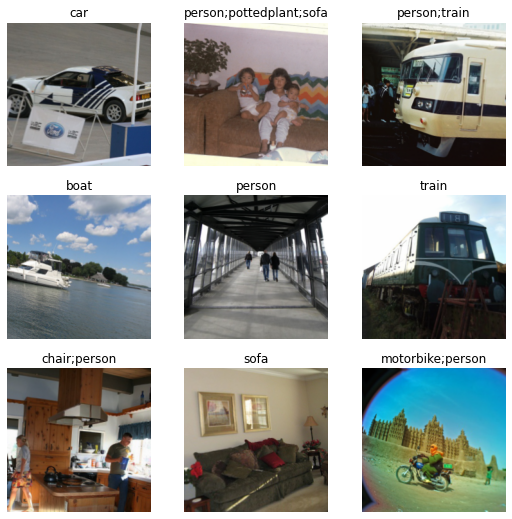

In [26]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=lambda x:pascal_source/"train"/f'{x[0]}',
                   get_y=lambda x:x[1].split(' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = pascal.dataloaders(df)
dls.show_batch()

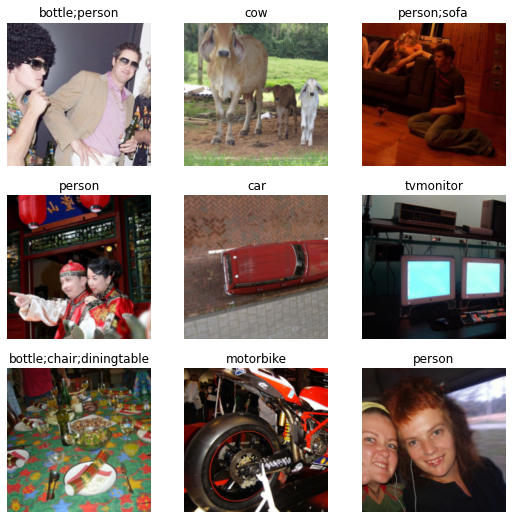

In [27]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=lambda o:f'{pascal_source}/train/'+o.fname,
                   get_y=lambda o:o.labels.split(),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

dls = pascal.dataloaders(df)
dls.show_batch()

In [28]:
def _pascal_items(x): return (
    f'{pascal_source}/train/'+x.fname, x.labels.str.split())
valid_idx = df[df['is_valid']].index.values

pascal = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=_pascal_items,
                   splitter=IndexSplitter(valid_idx),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

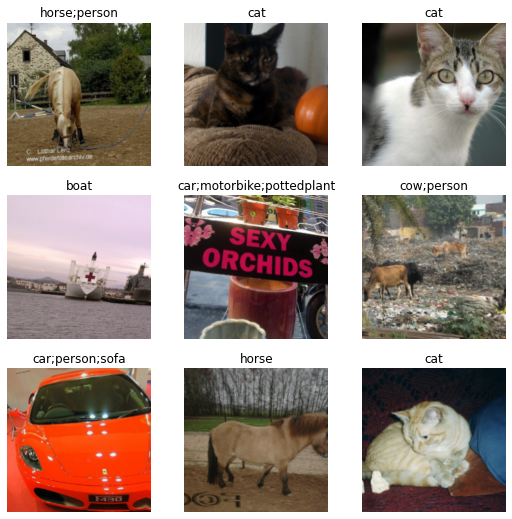

In [29]:
dls = pascal.dataloaders(df)
dls.show_batch()

In [30]:
path = untar_data(URLs.CAMVID_TINY)

In [31]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.loadtxt(path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=aug_transforms())

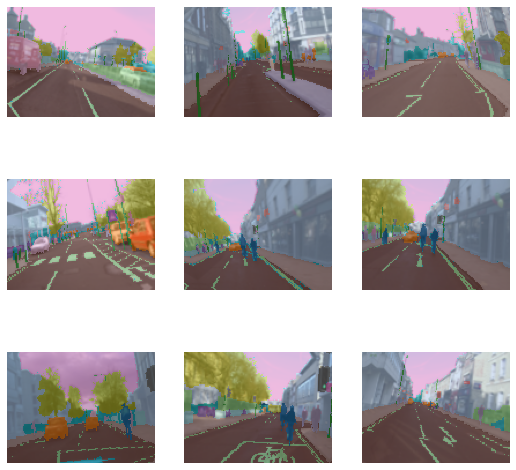

In [32]:
dls = camvid.dataloaders(path/"images")
dls.show_batch()

In [33]:
biwi_source = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = (biwi_source/'centers.pkl').load()

In [34]:
biwi = DataBlock(blocks=(ImageBlock, PointBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=lambda o:fn2ctr[o.name].flip(0),
                 batch_tfms=aug_transforms())

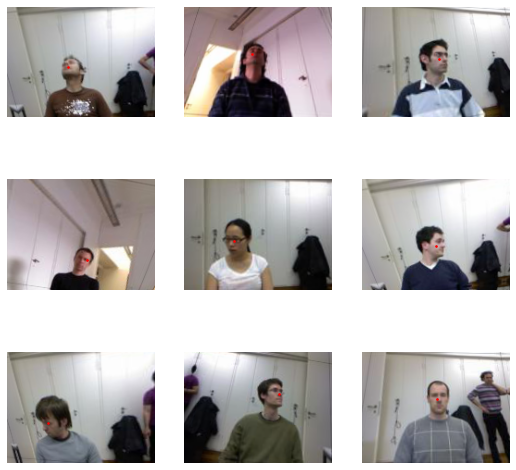

In [35]:
dls = biwi.dataloaders(biwi_source)
dls.show_batch(max_n=9)


In [36]:
coco_source = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco_source/'train.json')
img2bbox = dict(zip(images, lbl_bbox))

In [37]:
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)

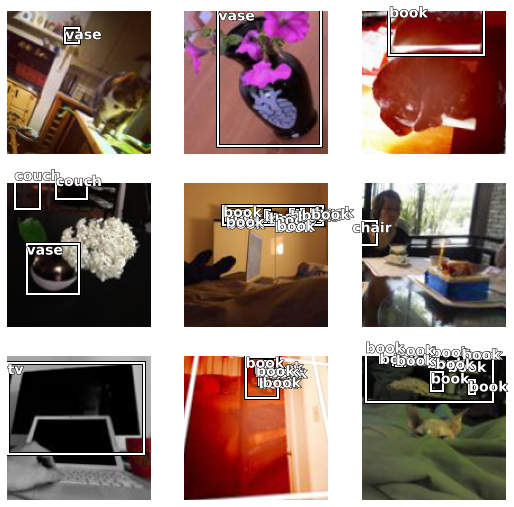

In [38]:
dls = coco.dataloaders(coco_source)
dls.show_batch(max_n=9)

### Text

In [39]:
from fastai2.text.all import *

In [40]:
path = untar_data(URLs.IMDB_SAMPLE)
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [42]:
imdb_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                    get_x=ColReader('text'),
                    splitter=ColSplitter())

In [43]:
dls = imdb_lm.dataloaders(df, bs=64, seq_len=72)
dls.show_batch(max_n=6)

,text,text_
0,"xxbos xxmaj as a former 2 time xxmaj xxunk xxmaj karate world xxunk , i like movies about sacrifice for sport . xxmaj but this movie is about so much more . xxmaj this movie is so good and so deep . i have recently been xxunk by very serious xxunk and pretty much a disastrous lack of passion . xxmaj almost lights out for me . xxmaj and this silly little","xxmaj as a former 2 time xxmaj xxunk xxmaj karate world xxunk , i like movies about sacrifice for sport . xxmaj but this movie is about so much more . xxmaj this movie is so good and so deep . i have recently been xxunk by very serious xxunk and pretty much a disastrous lack of passion . xxmaj almost lights out for me . xxmaj and this silly little movie"
1,"xxmaj what kind of xxunk horror has the woman keep a massive sports xxunk on during the obligatory sex scene ? ! xxmaj see , the movie ca n't even get that part right … xxbos xxmaj enjoyable in spite of xxmaj leslie xxmaj howard 's performance . xxmaj mr . xxmaj howard plays xxmaj philip as a flat , uninteresting character . xxmaj one is supposed to feel sorry for this","what kind of xxunk horror has the woman keep a massive sports xxunk on during the obligatory sex scene ? ! xxmaj see , the movie ca n't even get that part right … xxbos xxmaj enjoyable in spite of xxmaj leslie xxmaj howard 's performance . xxmaj mr . xxmaj howard plays xxmaj philip as a flat , uninteresting character . xxmaj one is supposed to feel sorry for this man"
2,"late - night xxmaj italian xxup tv xxunk ) : the three - hour epic xxup la xxup xxunk xxup de xxup xxunk ( 1948 ; also starring xxmaj gerard xxmaj xxunk ) , xxup the xxup second xxup twin ( xxunk ) and xxup the xxup legend xxup of xxup xxunk xxup king ( 1971 ; with xxmaj xxunk xxmaj xxunk and xxmaj xxunk xxmaj xxunk ) . xxbos i picked","- night xxmaj italian xxup tv xxunk ) : the three - hour epic xxup la xxup xxunk xxup de xxup xxunk ( 1948 ; also starring xxmaj gerard xxmaj xxunk ) , xxup the xxup second xxup twin ( xxunk ) and xxup the xxup legend xxup of xxup xxunk xxup king ( 1971 ; with xxmaj xxunk xxmaj xxunk and xxmaj xxunk xxmaj xxunk ) . xxbos i picked this"
3,"than the gay guys . \n\n xxmaj do n't get me wrong , xxmaj i m not saying all the gay guys were ugly and boring , as a matter of fact i found some of them very cute . xxmaj it 's just that overall they were just xxup blah compared to the men you 'd see on shows like a xxmaj shot xxmaj at xxmaj love with xxmaj xxunk xxmaj","the gay guys . \n\n xxmaj do n't get me wrong , xxmaj i m not saying all the gay guys were ugly and boring , as a matter of fact i found some of them very cute . xxmaj it 's just that overall they were just xxup blah compared to the men you 'd see on shows like a xxmaj shot xxmaj at xxmaj love with xxmaj xxunk xxmaj xxunk"
4,"so well , since this movie is actually based on stage play by xxmaj xxunk xxmaj xxunk . \n\n xxmaj it 's a technical really great movie , with also some great innovation camera - work in it and some really great editing , that create some fast going and pleasant to watch enjoyable sequences . xxmaj there is never a dull moment in this movie ! \n\n xxmaj xxunk xxmaj clair","well , since this movie is actually based on stage play by xxmaj xxunk xxmaj xxunk . \n\n xxmaj it 's a technical really great movie , with also some great innovation camera - work in it and some really great editing , that create some fast going and pleasant to watch enjoyable sequences . xxmaj there is never a dull moment in this movie ! \n\n xxmaj xxunk xxmaj clair was"
5,"a beautiful touch to it . xxmaj the performances from the xxunk are acceptable without making a huge mark . xxmaj gornick 's direction sticks to the nasty and rather gooey side . xxmaj while , the xxunk music score on this occasion pressed the right chords . xxmaj the xxunk - like creature in the lake ( like many have mentioned ) looks like an xxunk black xxunk ( yeah you","beautiful touch to it . xxmaj the performances from th

### Text Classification

In [44]:
imdb_clas = DataBlock(blocks=(TextBlock.from_df('text', seq_len=72, vocab=dls.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('label'),
                      splitter=ColSplitter())

In [45]:
dls = imdb_clas.dataloaders(df, bs=64)
dls.show_batch()

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxbos xxup the xxup shop xxup,positive
2,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,negative
3,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad,positive
4,xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xx

### Tabular Data

In [46]:
from fastai2.tabular.core import *

In [47]:
adult_source = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(adult_source/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [48]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']

In [49]:
procs = [Categorify, FillMissing, Normalize]

- `Categorify` will change the categorical columns into indices, 
- `FillMissing` will fill the missing values in the continuous columns (if any) and add an na categorical column (if necessary). 
- `Normalize` will normalize the continous columns (substract the mean and divide by the standard deviation).

In [50]:
splits = RandomSplitter()(range_of(df))

In [51]:
to = TabularPandas(df, procs, cat_names, cont_names, y_names="salary", splits=splits, y_block=CategoryBlock)

In [52]:
dls = to.dataloaders()
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,12th,Never-married,Adm-clerical,Own-child,White,False,17.0,331552.003709,8.0,<50k
1,Private,11th,Never-married,Exec-managerial,Unmarried,White,False,27.0,119169.998266,7.0,<50k
2,Private,Some-college,Never-married,Other-service,Not-in-family,Other,False,25.0,219129.999092,10.0,<50k
3,Private,HS-grad,Married-civ-spouse,Exec-managerial,Husband,White,False,50.0,94080.996890,9.0,>=50k
4,Private,Some-college,Never-married,Sales,Own-child,White,False,22.0,448626.008059,10.0,<50k
5,Private,HS-grad,Divorced,Craft-repair,Not-in-family,White,False,29.0,191534.999973,9.0,<50k
6,Self-emp-not-inc,Some-college,Married-civ-spouse,Farming-fishing,Husband,White,False,39.0,31847.997348,10.0,<50k
7,Private,12th,Never-married,Prof-specialty,Own-child,White,False,17.0,241184.998789,8.0,<50k
8,Private,11th,Married-civ-spouse,Craft-repair,Husband,White,False,46.0,155658.999926,7.0,>=50k
9,Self-emp-not-inc,Bachelors,Married-spouse-absent,Sales,Own-child,White,False,48.0,209057.000432,13.0,>=50k
